# Qubit dynamics simulation & QFI calculation

## Imports

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from qutip import Bloch, basis, mesolve, sigmax, sigmay, sigmaz, Options, ket2dm
from matplotlib import animation

## 1. Creating the Initial State of the System and Evolving it under Detuning, Driving and Dephasing, Utilizing the Function qutip.mesolve

### 1.1 Background

A single qubit can be represented as a quantum state vector $\left|\psi\right\rangle$ of a two-level quantum system, written as

$$\left|\psi\right\rangle=\alpha\left|0\right\rangle+\beta\left|1\right\rangle$$

with $\alpha,\beta\in\mathbb{C}$ satisfying the condition $\left|\alpha\right|^{2}+\left|\beta\right|^{2}=1$ ensuring that the state vector $\left|\psi\right\rangle$ is normalized.

By utilizing the normalization and indifference to global phase of the state vector $\left|\psi\right\rangle$, it can also be written as

$$\left|\psi\right\rangle =\cos\left(\frac{\theta}{2}\right)\left|0\right\rangle +e^{i\varphi}\sin\left(\frac{\theta}{2}\right)\left|1\right\rangle$$

with $\theta\in\left[0,\pi\right] , \varphi\in\left[0,2\pi\right]$. By describing $\left|\psi\right\rangle$ in such a way, it represents a point $\left(\theta,\varphi\right)$ (in Spherical coordinates) on a unit sphere called the Bloch sphere, and therefore in Cartesian coordinates $\left|\psi\right\rangle$ is represented by the unit vector $\left(\cos\varphi\sin\theta,\sin\varphi\sin\theta,\cos\theta\right)$ called the Bloch vector.

The Pauli vector is defined by

$$\vec{\sigma}=\sigma_{x}\hat{x}+\sigma_{y}\hat{y}+\sigma_{z}\hat{z}$$

and for any unit vector $\hat{n}$, the rotation operator

$$R_{\hat{n}}\left(\alpha\right)=\exp\left(-i\alpha\hat{n}\cdot\frac{\vec{\sigma}}{2}\right)=\cos\left(\frac{\alpha}{2}\right)\mathbb{I}-i\sin\left(\frac{\alpha}{2}\right)\hat{n}\cdot\vec{\sigma}$$

rotates the Bloch vector about the $\hat{n}$ axis by an angle $\alpha$.

Given a unit vector $\hat{n}$ in the direction defined by $\left(\theta,\varphi\right)$, i.e. $\hat{n}=\left(\sin\theta\cos\varphi,\sin\theta\sin\varphi,\cos\theta\right)$, $\hat{n}\cdot\vec{\sigma}$ is commonly denoted as

$$\sigma_{\theta,\varphi}\equiv\hat{n}\cdot\vec{\sigma}=\sin\theta\cos\varphi\sigma_{x}+\sin\theta\sin\varphi\sigma_{y}+\cos\theta\sigma_{z}$$

and the above-mentioned rotation operator can be written as

$$R_{\hat{n}}\left(\alpha\right)=\cos\left(\frac{\alpha}{2}\right)\mathbb{I}-i\sin\left(\frac{\alpha}{2}\right)\sigma_{\theta,\varphi}$$

Given the hamiltonian

$$\mathcal{H}=\xi\sigma_{\theta,\varphi}$$

the time evolution operator can be shown to satisfy

$$T\left(t\right)=e^{-\frac{i}{\hbar}\mathcal{H}t}=e^{-\frac{i}{\hbar}\xi\sigma_{\theta,\varphi}t}=\cos\left(\frac{\xi}{\hbar}t\right)\mathbb{I}-i\sin\left(\frac{\xi}{\hbar}t\right)\sigma_{\theta,\varphi}$$

and denoting $\xi\equiv\delta/2$ and $\delta'\equiv\delta/\hbar$

$$T\left(t\right)=\cos\left(\frac{\delta'}{2}t\right)\mathbb{I}-i\sin\left(\frac{\delta'}{2}t\right)\sigma_{\theta,\varphi}=R_{\hat{n}}\left(\delta'\cdot t\right)=R_{\hat{n}}\left(\frac{2\xi}{\hbar}t\right)$$

Therefore, applying the Hamiltonian $\mathcal{H}=\xi\sigma_{\theta,\varphi}$ upon a two-level quantum system for a duration of $t=\left(\hbar/2\xi\right)\alpha$, the state vector $\left|\psi\right\rangle$ of the system is rotated about the $\hat{n}$ axis by an angle of $\alpha$.

In our case, the two spin sublevels $m_{s}=0,-1$, with corresponding states $\left|0\right\rangle ,\left|-1\right\rangle$, form a two-level quantum system. An initial state

$$\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$$

is rotated about the $\hat{y}$ axis by an angle $\theta$

$$\left|\psi_{\theta}\left(0\right)\right\rangle \equiv R_{\hat{y}}\left(\theta\right)\left|\psi_{0}\left(0\right)\right\rangle$$

and then rotated about the $\hat{z}$ axis by an angle $\beta$

$$\left|\psi_{\theta}\left(\beta\right)\right\rangle \equiv R_{\hat{z}}\left(\beta\right)\left|\psi_{\theta}\left(0\right)\right\rangle =R_{\hat{z}}\left(\beta\right)R_{\hat{y}}\left(\theta\right)\left|\psi_{0}\left(0\right)\right\rangle$$

and from the Bloch vector discussion above, it is straightforward that

$$\left|\psi_{\theta}\left(0\right)\right\rangle =\cos\left(\frac{\theta}{2}\right)\left|0\right\rangle +\sin\left(\frac{\theta}{2}\right)\left|-1\right\rangle \,\,,\,\,\left|\psi_{\theta}\left(\beta\right)\right\rangle =\cos\left(\frac{\theta}{2}\right)\left|0\right\rangle +e^{i\beta}\sin\left(\frac{\theta}{2}\right)\left|-1\right\rangle$$

The rotations can be performed by applying $\mathcal{H}_{1}=\sigma_{y}$ on the initial qubit $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$ for $t_{1}=\left(\hbar/2\right)\theta$ amount of time, resulting a rotation of $\left|\psi_{0}\left(0\right)\right\rangle$ by an angle $\theta$ about the $\hat{y}$ axis, thus obtaining $\left|\psi_{\theta}\left(0\right)\right\rangle$, and then applying $\mathcal{H}_{2}=\Delta\sigma_{z}$ ($\Delta$ is the detuning) on the initial state $\left|\psi_{\theta}\left(0\right)\right\rangle$ for $t_{2}$ amount of time, where $t_{2}=\left(\hbar/2\Delta\right)\beta$ would result in a rotation of $\left|\psi_{\theta}\left(0\right)\right\rangle$ by an angle of $\beta$ about the $\hat{z}$ axis, obtaining $\left|\psi_{\theta}\left(\beta\right)\right\rangle$.

In our simulation, driving $\epsilon$ and dephasing $\gamma$ are also added to the rotation about the $\hat{z}$ axis, resulting in a more complex dynamics than the simpler case described above.
After obtaining the initial state of the system
$$\left|\psi_{\theta}\left(0\right)\right\rangle \equiv R_{\hat{y}}\left(\theta\right)\left|\psi_{0}\left(0\right)\right\rangle$$
the system is then evolved under the Hamiltonian
$$\mathcal{H}_{2}=\Delta\sigma_{z}+\epsilon\sigma_{x}$$
and dephasing collapse operator
$$C=\sqrt{\gamma}\sigma_{z}$$
for a duration of $t_{\text{final}}$, where $\Delta$ is the detuning, $\epsilon$ is the driving and $\gamma$ is the dephasing rate.

### 1.2 Summary

The initial qubit $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$ is prepared using the function psi_0_0_generator.

Then, the initial state of the system $\left|\psi_{\theta}\left(0\right)\right\rangle \equiv R_{\hat{y}}\left(\theta\right)\left|\psi_{0}\left(0\right)\right\rangle$ is prepared from $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$ by the function y_rotation, which evolves $\left|\psi_{0}\left(0\right)\right\rangle$ under the Hamiltonian $\mathcal{H}_{1}=\sigma_{y}$ for a duration of $t_{1}=\left(\hbar/2\right)\theta$.

$\left|\psi_{\theta}\left(0\right)\right\rangle$ is then evolved under the Hamiltonian $\mathcal{H}_{2}=\Delta\sigma_{z}+\epsilon\sigma_{x}$ and dephasing collapse operator $C=\sqrt{\gamma}\sigma_{z}$ for a duration of $t_{\text{final}}$ by the function z_rotation, producing the final state of the system, denoted as $\left|\psi_{\theta}\left(\beta\right)\right\rangle$.

The consequetive actions of y_rotation and z_rotation, both utilizing the function qutip.mesolve (qutip's master equation solver) to evolve their initial state $\left|\psi_{0}\left(0\right)\right\rangle$ and $\left|\psi_{\theta}\left(0\right)\right\rangle$ respectively, are combined under the function y_z_rotation, which returns $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ or all the states of the system throughout the entire evolution of $\left|\psi_{0}\left(0\right)\right\rangle$ into $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ along with their corresponding coordinates on the Bloch sphere.

y_z_rotation is only used in this section (see subsection 1.7), in order to plot an example of the evolution of $\left|\psi_{0}\left(0\right)\right\rangle$ into $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ and verify that the algorithms y_rotation and z_rotation work as expected.

### 1.3 Generating the Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$

psi_0_0_generator generates the initial qubit $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$, a Qobj of the type ket with the 0-th state (basis vector) occupied.

In [11]:
def psi_0_0_generator():

    """
    return: the initial qubit psi_0_0=|0>, a Qobj of the type ket with the 0-th state (basis vector) occupied
    """

    N = 2 # number of states (i.e. basis vectors) in the Hilbert space
    n = 0 # the state (basis vector) that will be occupied
    psi_0_0 = basis(N, n) # the initial qubit

    return psi_0_0

### 1.4 Preparing the Initial State of the System $\left|\psi_{\theta}\left(0\right)\right\rangle$

y_rotation evolves the initial state $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$ for a duration of $t_{1}=\left(1/2\right)\theta$ (in $\hbar=1$ units) under the Hamiltonian $\mathcal{H}_{1}=\sigma_{y}$, utilizing the function qutip.mesolve, resulting the final state to be $\left|\psi_{\theta}\left(0\right)\right\rangle \equiv R_{\hat{y}}\left(\theta\right)\left|\psi_{0}\left(0\right)\right\rangle$ , i.e. rotating $\left|\psi_{0}\left(0\right)\right\rangle$ about the $\hat{y}$ axis by an angle of $\theta$. $\left|\psi_{\theta}\left(0\right)\right\rangle$ would be used as the initial state of the system.

In [12]:
def y_rotation(psi_0_0, theta, continuous=False, tlist_length=100):
    """
    evolves the initial state psi_0_0 = |0> for a duration of t_1 = (1 / 2) * theta (in hbar=1 units) under the Hamiltonian H_1 = sigmay(), utilizing the function qutip.mesolve, resulting the final state to be psi_theta_0, i.e. rotating psi_0_0 about the y-axis by an angle of theta. psi_theta_0 would be used as the initial state of the system

    psi_0_0: should always be |0>, a Qobj of the type ket with the 0-th state (basis vector) occupied, conveniently obtained from the function psi_0_0_generator
    theta: the angle by which psi_0_0 is rotated (counter-clockwise) about the y-axis, into psi_theta_0
    continuous: see under return
    tlist_length: see under return
    
    return: if continuous = False, returns only the final qubit psi_theta_0, obtained from psi_0_0 by rotating it (counter-clockwise) by an angle of theta about the y-axis. 
    if continuous = True, returns an array of all the state vectors of the system throughout the entire evolution of psi_0_0 into psi_theta_0, along with arrays of their corresponding coordinates on the Bloch sphere, in time values corresponding to the values in the variable tlist, defined as a np.array with tlist_length evenly spaced values from 0 to t_1 = (1 / 2) * theta
    """

    # Hamiltonian H_1
    H_1 = sigmay()

    # final time of the rotation about the y-axis (taking into account that qutip uses hbar=1 units)
    t_1 = (1 / 2) * theta

    if continuous:
        # time array of the rotation about the y-axis
        tlist = np.linspace(0, t_1, tlist_length)

        # time evolution of psi_0_0 & expectation values of the pauli matrices for a duration of t_1, given the Hamiltonian H_1
        result = mesolve(H_1, psi_0_0, tlist, c_ops=None, e_ops=[sigmax(), sigmay(), sigmaz()], options=Options(store_states=True))

        # an array of all the state vectors corresponding to the time values in tlist
        psi_theta_0 = result.states

        # arrays of the pauli matrices expectation values corresponding to the time values in tlist
        pauli_exp_vals = result.expect

        return psi_theta_0, pauli_exp_vals

    else:
        # time array of the rotation about the y-axis
        tlist = np.array([0, t_1])

        # time evolution of psi_0_0 for a duration of t_1, given the Hamiltonian H_1
        result = mesolve(H_1, psi_0_0, tlist, c_ops=None)

        # the final qubit, obtained from psi_0_0 by rotating it (counter-clockwise) by an angle of theta about the y-axis
        psi_theta_0 = result.states[-1]

        return psi_theta_0

### 1.5 Evolving $\left|\psi_{\theta}\left(0\right)\right\rangle$ under Detuning, Driving and Dephasing

z_rotation evolves the initial state of the system $\left|\psi_{\theta}\left(0\right)\right\rangle$ for a duration of $t_{\text{final}}$ under the Hamiltonian $\mathcal{H}_{2}=\Delta\sigma_{z}+\epsilon\sigma_{x}$ and dephasing collapse operator $C=\sqrt{\gamma}\sigma_{z}$, utilizing the function qutip.mesolve. The obtained final state of the system is denoted as $\left|\psi_{\theta}\left(\beta\right)\right\rangle$.

In [13]:
def z_rotation(psi_theta_0, param_vec, continuous=False, tlist_length=100):
    """
    evolves the initial state of the system psi_theta_0 for a duration of t_final under the Hamiltonian H_2 = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz(), utilizing the function qutip.mesolve. The obtained final state of the system is denoted as psi_theta_beta

    psi_theta_0: the initial state of the system, obtained from psi_0_0 by using the function y_rotation
    param_vec: np.array containing the parameter values [t_final, Delta, epsilon, gamma]. t_final is the total duration of the time evolution of psi_theta_0 under the Hamiltonian H_2 = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz(), where Delta is the detuning, epsilon is the driving and gamma is the dephasing rate
    continuous: see under return
    tlist_length: see under return
    
    return: if continuous = False, returns psi_theta_beta. if continuous=True, returns all the states of the system throughout the entire evolution of psi_theta_0 into psi_theta_beta along with their corresponding coordinates on the Bloch sphere, in time values corresponding to the values in the variable tlist, defined as a np.array with tlist_length evenly spaced values from 0 to t_final
    """

    t_final, Delta, epsilon, gamma = param_vec # t_final, Delta, epsilon and gamma are the duration of time evolution, detuning, driving and dephasing rate respectively

    # Hamiltonian H
    H_2 = (Delta * sigmaz()) + (epsilon * sigmax())

    # dephasing collapse operator
    C = np.sqrt(gamma) * sigmaz()

    if continuous:
        # time array of the time evolution of psi_theta_0 under the Hamiltonian H_2 and the dephasing collapse operator C
        tlist = np.linspace(0, t_final, tlist_length)

        # time evolution of psi_theta_0 & expectation values of the pauli matrices for a duration of t_final, under the Hamiltonian H_2 and the dephasing collapse operator C
        result = mesolve(H_2, psi_theta_0, tlist, c_ops=[C], e_ops=[sigmax(), sigmay(), sigmaz()], options=Options(store_states=True))

        # an array of all the state vectors corresponding to the time values in tlist
        psi_theta_beta = result.states

        # arrays of the pauli matrices expectation values corresponding to the time values in tlist
        pauli_exp_vals = result.expect

        return psi_theta_beta, pauli_exp_vals

    else:
        # time array of the time evolution of psi_theta_0 under the Hamiltonian H_2 and the dephasing collapse operator C
        tlist = np.array([0, t_final])

        # time evolution of psi_theta_0 for a duration of t_final, under the Hamiltonian H_2 and the dephasing collapse operator C
        result = mesolve(H_2, psi_theta_0, tlist, c_ops=[C])

        # the final qubit, obtained from the time evolution of psi_theta_0 under the Hamiltonian H_2 and the dephasing collapse operator C for a duration of t_final
        psi_theta_beta = result.states[-1]

        return psi_theta_beta

### 1.6 Generating param_vec with $t_{\text{final}}$ According to $\beta$

param_vec_generator_beta generates param_vec, which is a np.array containing the parameter values $\left[t_{\text{final}},\,\Delta,\,\epsilon,\,\gamma\right]$. $t_{\text{final}}$ is the total duration of the time evolution of $\left|\psi_{\theta}\left(0\right)\right\rangle$ under the Hamiltonian $\mathcal{H}_{2}=\Delta\sigma_{z}+\epsilon\sigma_{x}$ and dephasing collapse operator $C=\sqrt{\gamma}\sigma_{z}$, where $\Delta$ is the detuning, $\epsilon$ is the driving and $\gamma$ is the dephasing rate. $t_{\text{final}}$ is calculated such that if there was only detuning (i.e. in the case of $\epsilon=\gamma=0$), $\left|\psi_{\theta}\left(0\right)\right\rangle$ would be rotated (counter-clockwise) about the $\hat{z}$ axis by an angle of $\beta$.

In [6]:
def param_vec_generator_beta(beta, Delta, epsilon, gamma):

    """
    generates param_vec=np.array([t_final, Delta, epsilon, gamma]). t_final is the total duration of the time evolution of psi_theta_0 under the Hamiltonian H_2 = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz(), where Delta is the detuning, epsilon is the driving and gamma is the dephasing rate. t_final is calculated such that if there was only detuning (i.e. in the case of epsilon=gamma=0), psi_theta_0 would be rotated (counter-clockwise) about the z-axis by an angle of beta

    beta: angle of (counter-clockwise) rotation about the z-axis if there was only detuning (i.e. in the case of epsilon=gamma=0). t_final=(1/(2*Delta))*beta (taking into account that qutip uses hbar=1 units)
    Delta: the detuning
    epsilon: the driving
    gamma: the dephasing rate
    
    return: param_vec=np.array([t_final, Delta, epsilon, gamma]), where t_final is calculated such that if there was only detuning (i.e. in the case of epsilon=gamma=0), psi_theta_0 would be rotated (counter-clockwise) about the z-axis by an angle of beta
    """

    # the total duration of the time evolution of psi_theta_0 (i.e. psi_0_0 after it is rotated (counter-clockwise) by an angle of theta about the y-axis) under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
    t_final = (1 / (2 * Delta)) * beta

    param_vec = np.array([t_final, Delta, epsilon, gamma])

    return param_vec

### 1.7 From Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle$ Into Final State $\left|\psi_{\theta}\left(\beta\right)\right\rangle$

y_z_rotation evolves the initial qubit $\left|\psi_{0}\left(0\right)\right\rangle =\left|0\right\rangle$ into the initial state of the system $\left|\psi_{\theta}\left(0\right)\right\rangle$ by utilizing the function y_rotation, and then evolves $\left|\psi_{\theta}\left(0\right)\right\rangle$ for a duration of $t_{\text{final}}$ under the Hamiltonian $\mathcal{H}_{2}=\Delta\sigma_{z}+\epsilon\sigma_{x}$ and dephasing collapse operator $C=\sqrt{\gamma}\sigma_{z}$ into the final state of the system $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ by utilizing the function z_rotation, where $\Delta$ is the detuning, $\epsilon$ is the driving and $\gamma$ is the dephasing rate.

In [9]:
def y_z_rotation(psi_0_0, theta, param_vec, show_stages=False, continuous=False, tlist_length=100):
    """
    evolves the initial qubit psi_0_0 = |0> into the initial state of the system psi_theta_0 by utilizing the function y_rotation, and then evolves psi_theta_0 for a duration of t_final under the Hamiltonian H_2 = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz() into the final state of the system psi_theta_beta by utilizing the function z_rotation, where Delta is the detuning, epsilon is the driving and gamma is the dephasing rate

    psi_0_0: should always be |0>, a Qobj of the type ket with the 0-th state (basis vector) occupied, conveniently obtained from the function psi_0_0_generator
    theta: the angle by which psi_0_0 is rotated (counter-clockwise) about the y-axis, into psi_theta_0
    param_vec: np.array containing the parameter values [t_final, Delta, epsilon, gamma]. t_final is the total duration of the time evolution of psi_theta_0 under the Hamiltonian H_2 = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz(), where Delta is the detuning, epsilon is the driving and gamma is the dephasing rate
    show_stages: see under return
    continuous: see under return
    tlist_length: see under return
    
    return: if show_stages=False, returns psi_theta_beta. if show_stages=True, then if continuous=True it returns all the states of the system throughout the entire evolution of psi_0_0 into psi_theta_beta along with their corresponding coordinates on the Bloch sphere in time values corresponding to the values in the variables tlist in y_rotation and z_rotation defined as a np.array with tlist_length evenly spaced values from 0 to t_1 or t_final respectively, and if continuous=False it returns psi_0_0, psi_theta_0, psi_theta_beta
    """

    if continuous:
        # arrays of all the state vectors & pauli matrices expectation values calculated along the time evolution of psi_0_0 as it was rotated (counter-clockwise) by an angle of theta about the y-axis
        psi_theta_0, pauli_exp_vals_theta_0 = y_rotation(psi_0_0, theta, continuous, tlist_length)

        # arrays of all the state vectors & pauli matrices expectation values calculated along the time evolution of psi_theta_0[-1] under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
        psi_theta_beta, pauli_exp_vals_theta_beta = \
            z_rotation(psi_theta_0[-1], param_vec, continuous, tlist_length)

    else:
        # the qubit obtained from psi_0_0 by rotating it (counter-clockwise) by an angle of theta about the y-axis
        psi_theta_0 = y_rotation(psi_0_0, theta)

        # the qubit obtained from psi_theta_0 by evolving it under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz() for a duration of t_final
        psi_theta_beta = z_rotation(psi_theta_0, param_vec)

    if show_stages:
        if continuous:
            return psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta
        else:
            return psi_0_0, psi_theta_0, psi_theta_beta
    else:
        return psi_theta_beta

### 1.8 From Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle$ Into Final State $\left|\psi_{\theta}\left(\beta\right)\right\rangle$: An Example

note:

In the following example, the evolution of $\left|\psi_{0}\left(0\right)\right\rangle$ into $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ is plotted upon the Bloch sphere, given the input arguments $\theta=\pi/2$, $\beta=\pi/4$, $\Delta=1$, $\epsilon=0.2$ and $\gamma=0.1\Delta$.

In [14]:
# defining initial qubit
psi_0_0 = psi_0_0_generator()

# angle of (counter-clockwise) rotation about the y-axis
theta = np.pi / 2

# defining param_vec
param_vec = param_vec_generator_beta(beta=np.pi/4, Delta=1, epsilon=1, gamma=0.1)

In [15]:
# rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
    y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# seperating the expectation values of the pauli matrices. at each moment they're equal to the cartesian coordinates (x,y,z) of the Bloch vector
sigmax_exp_vals_theta_0, sigmay_exp_vals_theta_0, sigmaz_exp_vals_theta_0 = pauli_exp_vals_theta_0
sigmax_exp_vals_theta_beta, sigmay_exp_vals_theta_beta, sigmaz_exp_vals_theta_beta = pauli_exp_vals_theta_beta

C:\Users\Owner\PycharmProjects\QEC\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


#### 1.8.1 Bloch Sphere Plot of the Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle$ (In Green),  the Initial State $\left|\psi_{\theta}\left(0\right)\right\rangle$ (In Brown) and the Final State $\left|\psi_{\theta}\left(\beta\right)\right\rangle$ (In Blue)

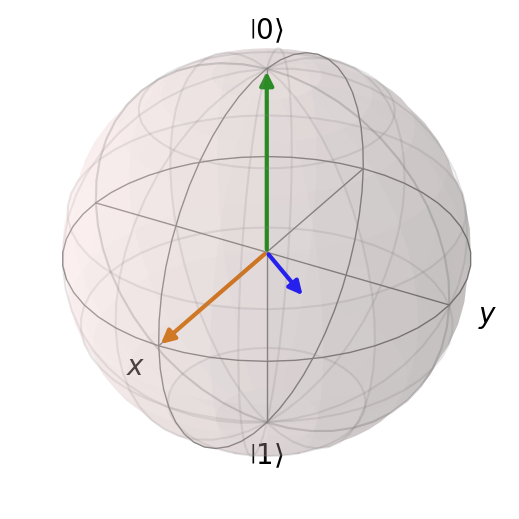

In [10]:
# creating a Bloch sphere plot of the initial qubit psi_0_0 (in green), psi_theta_0 (in brown) and psi_theta_beta (in blue)
sphere = Bloch()
sphere.add_states([psi_0_0, psi_theta_0[-1], psi_theta_beta[-1]])
sphere.show()
sphere.save('1.8.1_bloch_sphere_initial_qubit_initial_state_final_state.png')

#### 1.8.2 Bloch Sphere Plot of the Continuous Change, From Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle$ Into Final State $\left|\psi_{\theta}\left(\beta\right)\right\rangle$

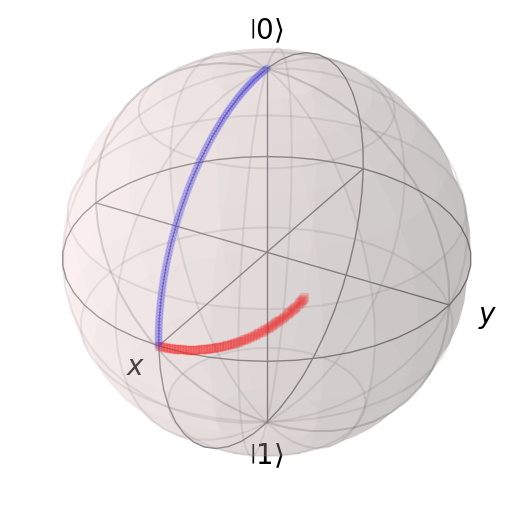

In [11]:
# creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis (in blue, from top to bottom), and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz() (in red, from left to right)
sphere = Bloch()
# sphere.add_states([psi_0_0, psi_theta_0[-1], psi_theta_beta[-1]])
sphere.add_points([sigmax_exp_vals_theta_0, sigmay_exp_vals_theta_0, sigmaz_exp_vals_theta_0],alpha=0.15)
sphere.add_points([sigmax_exp_vals_theta_beta, sigmay_exp_vals_theta_beta, sigmaz_exp_vals_theta_beta],alpha=0.15)
sphere.show()
sphere.save('1.8.2_bloch_sphere_from_initial_qubit_to_final_state_trajectory.png')

#### 1.8.3 Bloch Sphere Animation of the Continuous Change, From Initial Qubit $\left|\psi_{0}\left(0\right)\right\rangle$ Into Final State $\left|\psi_{\theta}\left(\beta\right)\right\rangle$

note: for further explanations about the Bloch Sphere animation, check out https://qutip.readthedocs.io/en/latest/guide/guide-bloch.html under "Animating with the Bloch sphere". Also, check out https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html for explanations about the position of the viewport "camera" in a 3D plot, which is defined by three angles: elevation, azimuth, and roll.

##### 1.8.3.1 Continuous Trajectory on the Bloch Sphere

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

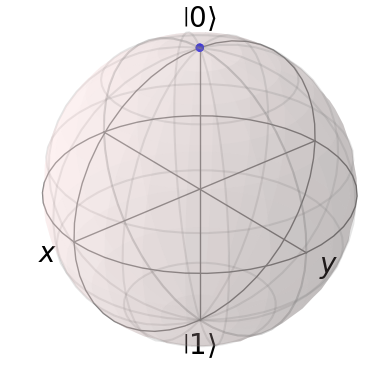

In [16]:
## calculating
# defining initial qubit
psi_0_0 = psi_0_0_generator()

# angle of (counter-clockwise) rotation about the y-axis
theta = np.pi / 2

# defining param_vec
param_vec = param_vec_generator_beta(beta=np.pi/4, Delta=1, epsilon=1, gamma=0.1)

# rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
    y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# seperating the expectation values of the pauli matrices. at each moment they're equal to the cartesian coordinates (x,y,z) of the Bloch vector
sigmax_exp_vals_theta_0, sigmay_exp_vals_theta_0, sigmaz_exp_vals_theta_0 = pauli_exp_vals_theta_0
sigmax_exp_vals_theta_beta, sigmay_exp_vals_theta_beta, sigmaz_exp_vals_theta_beta = pauli_exp_vals_theta_beta

# sigmax, sigmay and sigmaz expectation values throughout the time evolution from psi_0_0 to psi_theta_beta
sx = np.concatenate((sigmax_exp_vals_theta_0, sigmax_exp_vals_theta_beta[1:]), axis=None)
sy = np.concatenate((sigmay_exp_vals_theta_0, sigmay_exp_vals_theta_beta[1:]), axis=None)
sz = np.concatenate((sigmaz_exp_vals_theta_0, sigmaz_exp_vals_theta_beta[1:]), axis=None)
##

initialization_end_index = len(psi_theta_0) # the index in sx (and sy and sz) at which the system is in its initialized state psi_theta_0
print()

## animation
# creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then by an angle of beta about the z-axis
# # commented-out for the time being because it is not necessary to produce the video
fig = plt.figure()
ax = fig.add_subplot(azim=-40, elev=30, projection="3d")
sphere = Bloch(axes=ax)
def state_vector_trajectory_animate(i):
    sphere.clear()

    if i < initialization_end_index:
        sphere.add_points([sx[:i+1], sy[:i+1], sz[:i+1]])
    else:
        sphere.add_points([sx[:initialization_end_index], sy[:initialization_end_index], sz[:initialization_end_index]])
        sphere.add_points([sx[initialization_end_index:i+1], sy[initialization_end_index:i+1], sz[initialization_end_index:i+1]])

    sphere.make_sphere()
    return ax

# commented-out for the time being because it is not necessary to produce the video
ani = animation.FuncAnimation(fig, state_vector_trajectory_animate, np.arange(len(sx)), blit=False, repeat=False)
ani.save('1.8.3.1_bloch_sphere_from_initial_qubit_to_final_state_trajectory_animation.mp4', fps=40)

##### 1.8.3.2 Continuous State Vector Evolution

c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


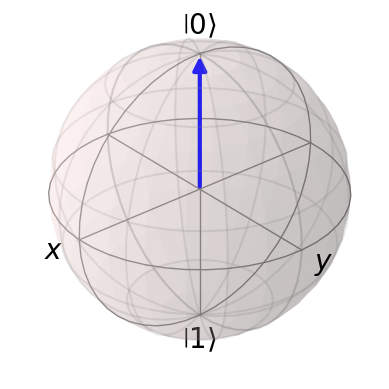

In [13]:
## calculating
# defining initial qubit
psi_0_0 = psi_0_0_generator()

# angle of (counter-clockwise) rotation about the y-axis
theta = np.pi / 2

# defining param_vec
param_vec = param_vec_generator_beta(beta=np.pi/4, Delta=1, epsilon=1, gamma=0.1)

# rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
    y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0

## animation
# creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then by an angle of beta about the z-axis
# commented-out for the time being because it is not necessary to produce the video
fig = plt.figure()
ax = fig.add_subplot(azim=-40, elev=30, projection="3d")
sphere = Bloch(axes=ax)
def state_vector_evolution_animate(i):
   sphere.clear()

   if i < initialization_end_index:
      sphere.vector_color = ['b']
   else:
      sphere.vector_color = ['r']

   sphere.add_states([psi_0_0_to_psi_theta_beta[i]])
   sphere.make_sphere()
   return ax

# commented-out for the time being because it is not necessary to produce the video
ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
ani.save('1.8.3.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation.mp4', fps=40)

1.8.3.3.1

c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


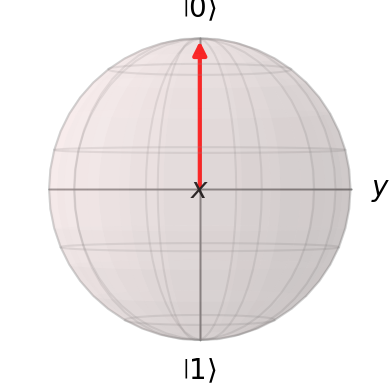

In [19]:
## calculating
# defining initial qubit
psi_0_0 = psi_0_0_generator()

# angle of (counter-clockwise) rotation about the y-axis
theta = 0

# defining param_vec
t = 20
Δ = 0
ε = 1
γ = 0.001
param_vec = np.array([t, Δ, ε, γ])

# rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()


psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
    z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=200)

## animation
# creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then by an angle of beta about the z-axis
# commented-out for the time being because it is not necessary to produce the video
fig = plt.figure()
ax = fig.add_subplot(azim=-90, elev=0, projection="3d")
sphere = Bloch(axes=ax)

def state_vector_evolution_animate(i):
   sphere.clear()
   sphere.vector_color = ['r']
   sphere.add_states([psi_theta_beta[i]])
   sphere.make_sphere()
   return ax

# commented-out for the time being because it is not necessary to produce the video
ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_theta_beta)), blit=False, repeat=False)
ani.save('1.8.3.3.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation.mp4', fps=40)

1.8.3.3.2

##### 2.6.1

2.6.1.1

In [41]:
# # "original"

# Delta_min = -2
# Delta_max = 2
# epsilon_min = 0.001
# epsilon_max = 1

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 50

# grid_length = 50

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("2.6.1.1_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.1_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.1_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("2.6.1.1_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [42]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('2.6.1.1_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('2.6.1.1_max_QFI_contour_original.png')
# ##

In [43]:
# # defining Delta and epsilon: change manually to verify the reuslts of the 2-D graphs above
# Delta = 1.35
# epsilon = 0.98

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# # defining param_vec
# param_vec = np.array([t_final, Delta, epsilon, gamma])

# ###########################################################################################################

# ## "original" QFI(theta) plot

# # defining minimum and maximum values of theta
# theta_min = 0
# theta_max = np.pi

# # defining the length of theta_array and QFI_array
# theta_array_length = 100

# # calculating the QFI of param_QFI as a function of theta, where theta ranges from theta_min to theta_max
# theta_array, QFI_array = QFI_theta_calculator_12_original(psi_0_0, param_vec, param_QFI, h, theta_min, theta_max, theta_array_length)

# max_QFI = np.max(QFI_array) # max QFI
# max_QFI_index = np.where(QFI_array == max_QFI)[0][0]
# max_QFI_theta = theta_array[max_QFI_index] # theta at max QFI
# display(Latex(r"$\theta\text{ at max QFI:}$" + ' ' + str(np.round(max_QFI_theta*(180/np.pi), 2)) + ' degrees')) # + str(max_QFI_theta)))
# # print(max_QFI_theta)

# min_QFI = np.min(QFI_array) # min QFI
# min_QFI_index = np.where(QFI_array == min_QFI)[0][0]
# min_QFI_theta = theta_array[min_QFI_index] # theta at min QFI
# # print('min_QFI_theta =', min_QFI_theta)

# # plt.rcParams['font.size'] = '16'

# fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(theta_array, QFI_array, linewidth=2, label=r'$\gamma=$'+str(gamma))

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + r'$, \Delta=$' + str(Delta) + r'$, \epsilon=$' + str(epsilon) + "; formula (12)", size='18')
# ax.set_xlabel(r'$\theta$', size='22')
# ax.set_ylabel(r'$\mathcal{F}_{\Delta}$', size='22')

# # customizing the x-axis tick labels to be in radians
# ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2, (2/3)*np.pi, (5/6)*np.pi, np.pi])
# ax.set_xticklabels(['$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$',r'$\pi$'])

# ax.tick_params(axis='x', labelsize=20)  # Set the fontsize for x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis tick labels

# ax.legend(fontsize=14)

# plt.tight_layout()

# fig.savefig('2.6.1.1_Delta_QFI_by_theta_12_original.png')
# ##

# ### Bloch Sphere Animation of the Continuous State Vector Evolution, From Initial Qubit psi_0_0 Into Final State psi_theta_beta


# # 1. for chosen theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# # theta = 0.8 * max_QFI_theta
# theta = 0.8 * max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_z_axis.mp4', fps=40)
# ##

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_x_axis.mp4', fps=20)
# ##


# # 2. for theta = max_QFI_theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_x_axis.mp4', fps=20)

# # 3. for theta = min_QFI_theta

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = min_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_x_axis.mp4', fps=20)

# ###

2.6.1.2

In [44]:
# # "original"

# Delta_min = -2
# Delta_max = 2
# epsilon_min = 0.001
# epsilon_max = 0.2

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 60

# grid_length = 60

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("2.6.1.2_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.2_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.2_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("2.6.1.2_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [45]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('2.6.1.2_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('2.6.1.2_max_QFI_contour_original.png')
# ##

In [46]:
# # defining Delta and epsilon: change manually to verify the reuslts of the 2-D graphs above
# Delta = 2
# # epsilon = 0.03
# epsilon = 0.01

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# # defining param_vec
# param_vec = np.array([t_final, Delta, epsilon, gamma])

# ###########################################################################################################

# ## "original" QFI(theta) plot

# # defining minimum and maximum values of theta
# theta_min = 0
# theta_max = np.pi

# # defining the length of theta_array and QFI_array
# theta_array_length = 100

# # calculating the QFI of param_QFI as a function of theta, where theta ranges from theta_min to theta_max
# theta_array, QFI_array = QFI_theta_calculator_12_original(psi_0_0, param_vec, param_QFI, h, theta_min, theta_max, theta_array_length)

# max_QFI = np.max(QFI_array) # max QFI
# max_QFI_index = np.where(QFI_array == max_QFI)[0][0]
# max_QFI_theta = theta_array[max_QFI_index] # theta at max QFI
# display(Latex(r"$\theta\text{ at max QFI:}$" + ' ' + str(np.round(max_QFI_theta*(180/np.pi), 2)) + ' degrees')) # + str(max_QFI_theta)))
# # print(max_QFI_theta)

# min_QFI = np.min(QFI_array) # min QFI
# min_QFI_index = np.where(QFI_array == min_QFI)[0][0]
# min_QFI_theta = theta_array[min_QFI_index] # theta at min QFI
# # print('min_QFI_theta =', min_QFI_theta)

# # plt.rcParams['font.size'] = '16'

# fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(theta_array, QFI_array, linewidth=2, label=r'$\gamma=$'+str(gamma))

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + r'$, \Delta=$' + str(Delta) + r'$, \epsilon=$' + str(epsilon) + "; formula (12)", size='18')
# ax.set_xlabel(r'$\theta$', size='22')
# ax.set_ylabel(r'$\mathcal{F}_{\Delta}$', size='22')

# # customizing the x-axis tick labels to be in radians
# ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2, (2/3)*np.pi, (5/6)*np.pi, np.pi])
# ax.set_xticklabels(['$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$',r'$\pi$'])

# ax.tick_params(axis='x', labelsize=20)  # Set the fontsize for x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis tick labels

# ax.legend(fontsize=14)

# plt.tight_layout()

# fig.savefig('2.6.1.2_Delta_QFI_by_theta_12_original.png')
# ##

# ### Bloch Sphere Animation of the Continuous State Vector Evolution, From Initial Qubit psi_0_0 Into Final State psi_theta_beta


# # 1. for chosen theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# # theta = 0.8 * max_QFI_theta
# theta = 0.8 * max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_z_axis.mp4', fps=40)
# ##

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_x_axis.mp4', fps=20)
# ##


# # 2. for theta = max_QFI_theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_x_axis.mp4', fps=20)

# # 3. for theta = min_QFI_theta

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = min_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('2.6.1.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_x_axis.mp4', fps=20)

###

2.6.1.3

In [47]:
# # "original"

# Delta_min = -2
# Delta_max = 2
# epsilon_min = 0.001
# epsilon_max = 0.2

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 80

# grid_length = 80

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("2.6.1.3_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.3_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.3_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("2.6.1.3_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [48]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('2.6.1.3_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('2.6.1.3_max_QFI_contour_original.png')
# ##

2.6.1.4

In [49]:
# # "original"

# Delta_min = -2
# Delta_max = 2
# epsilon_min = 0.001
# epsilon_max = 0.2

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 100

# grid_length = 100

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("2.6.1.4_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.4_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("2.6.1.4_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("2.6.1.4_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [50]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('2.6.1.4_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('2.6.1.4_max_QFI_contour_original.png')
# ##

## 3.

### 3.1 Background

Our system evolves under the Hamiltonian

$$\mathcal{H}=\Delta\sigma_{z}+\epsilon\sigma_{x}$$

and dephasing collapse operator

$$C=\sqrt{\gamma}\sigma_{z}$$

where $\Delta$ is the detuning, $\epsilon$ is the driving and $\gamma$ is the dephasing rate.

The most general trace-preserving and completely positive form describing the evolution of a system interacting with its environment is the Lindblad master equation for the reduced density matrix $\rho=\text{Tr}_{\text{env}}\left(\rho_{\text{tot}}\right)$, given by (in units where $\hbar=1$)

$$\dot{\rho}=\mathcal{L}\left(\rho\right)=-i\left[\mathcal{H},\rho\right]+\sum_{n}\left[C_{n}\rho C_{n}^{\dagger}-\frac{1}{2}\left\{ C_{n}^{\dagger}C_{n},\rho\right\} \right]$$

in the formalism of https://qutip.org/docs/4.0.2/guide/dynamics/dynamics-master.html, where the $C_{n}=\sqrt{\gamma_{n}}A_{n}$ are collapse operators, and $A_{n}$ are the operators through which the environment couples to the system in $\mathcal{H}_{\text{int}}$, and $\gamma_{n}$ are the corresponding rates.

The Lindbladian $\mathcal{L}$ can be represented as a $4\times4$ matrix $L$, e.g. in the operator basis $\left\{ \left|g\right\rangle \left\langle g\right|,\left|e\right\rangle \left\langle g\right|,\left|g\right\rangle \left\langle e\right|,\left|e\right\rangle \left\langle e\right|\right\}$, where in this operator basis the multiplication of $L$ onto a vector $\vec{r}=\left(\rho_{gg},\rho_{eg},\rho_{ge},\rho_{ee}\right)^{\text{T}}$ yields precisely the action of the Lindbladian $\mathcal{L}$ on the density matrix $\rho$, i.e. $\dot{\rho}$. 

It can be shown that in the operator basis $\left\{ \left|g\right\rangle \left\langle g\right|,\left|e\right\rangle \left\langle g\right|,\left|g\right\rangle \left\langle e\right|,\left|e\right\rangle \left\langle e\right|\right\}$ the matrix representation of the Lindbladian is

$$L=\begin{pmatrix}0 & -i\epsilon & i\epsilon & 0\\
-i\epsilon & 2\left(i\Delta-\gamma\right) & 0 & i\epsilon\\
i\epsilon & 0 & -2\left(i\Delta+\gamma\right) & -i\epsilon\\
0 & i\epsilon & -i\epsilon & 0
\end{pmatrix}$$

### 3.2

In [51]:
def Lindbladian(Delta, epsilon, gamma):

    # given the input parameters Delta, epsilon and gamma, representing the detuning, driving and dephasing rate respectively, Lindbladian returns L, which is the Lindbladian in the case where the system evolves under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and dephasing collapse operator C = np.sqrt(gamma) * sigmaz()

    L = np.zeros([4, 4], dtype=complex)

    L[0, 1] = (-1j) * epsilon
    L[0, 2] = 1j * epsilon

    L[1, 0] = (-1j) * epsilon
    L[1, 1] = 2 * ((1j * Delta) - gamma)
    L[1, 3] = 1j * epsilon

    L[2, 0] = 1j * epsilon
    L[2, 2] = (-2) * ((1j * Delta) + gamma)
    L[2, 3] = (-1j) * epsilon

    L[3, 1] = 1j * epsilon
    L[3, 2] = (-1j) * epsilon
    
    return L

In [52]:
def Lindbladian_eigenvalues_triangle_calculator(Delta_min, Delta_max, epsilon_min, epsilon_max, gamma, grid_length=1000):

    # for a given gamma, calculates whether all the eigenvalues are real, for any (epsilon, Delta) point in the parameter space defined by the epsilon_mesh & Delta_mesh grid. returns epsilon_mesh, Delta_mesh, are_eigenvalues_real_array. epsilon is within the range [epsilon_min, epsilon_max] and Delta is within the range [Delta_min, Delta_max]

    epsilon_array = np.linspace(epsilon_min, epsilon_max, grid_length)
    Delta_array = np.linspace(Delta_min, Delta_max, grid_length)
    epsilon_mesh, Delta_mesh = np.meshgrid(epsilon_array, Delta_array, indexing='xy') # epsilon and Delta coordinates, respectively. see notes about indexing at "https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html". choosing 'xy' indexing, if the order of the loops in those notes is reversed, then i and j in the inner loop should be replaced, i.e. iterating over y with the index i and then over x with the index j the last line can be changed to: # treat xv[i,j], yv[i,j]
    are_eigenvalues_real_array = np.zeros_like(epsilon_mesh, dtype=bool) # array for storing whether all the eigenvalues are real, for any (epsilon, Delta) point in the parameter space. it is initialized as an array of False values

    # iterating to calculate whether all the eigenvalues are real, for any (epsilon, Delta) point in the parameter space defined by epsilon_mesh & Delta_mesh
    for i, Delta in enumerate(Delta_array):
        for j, epsilon in enumerate(epsilon_array):
            L = Lindbladian(Delta, epsilon, gamma) # computing the Lindbladian
            eigenvalues = np.linalg.eigvals(L) # computing the Lindbladian's eigenvalues

            # if all the eigenvalues are real, changes the stored value from False to True
            # if (np.max(np.abs(eigenvalues.imag)) < 1e-16) and np.all(np.abs(eigenvalues.imag) < ((1e-2)*np.abs(eigenvalues.real))):
            #     are_eigenvalues_real_array[i, j] = True

            if (np.max(np.abs(eigenvalues.imag)) < 1e-16) and np.all(np.abs(eigenvalues.imag) < ((1e-1)*np.abs(eigenvalues.real))):
                are_eigenvalues_real_array[i, j] = True

    return epsilon_mesh, Delta_mesh, are_eigenvalues_real_array

### 3.3 Calculating whether all the eigenvalues are real, given $\gamma=0.1$, for $\Delta\in\left[-0.1,0.1\right]$, $\epsilon\in\left[0,0.03\right]$

note: the following code sections are commented-out for the time being because they're not important at the moment

#### 3.3.1

In [53]:
# Delta_min = -0.02
# Delta_max = 0.02
# epsilon_min = 0
# epsilon_max = 0.055

# gamma = 0.1

# grid_length = 1600

# epsilon_mesh, Delta_mesh, are_eigenvalues_real_array = Lindbladian_eigenvalues_triangle_calculator(Delta_min, Delta_max, epsilon_min, epsilon_max, gamma, grid_length)

In [54]:
# # inside the triangle: only real eigenvalues. outside the triangle: complex eigenvalues
# fig, ax = plt.subplots()
# ax.contourf(epsilon_mesh, Delta_mesh, are_eigenvalues_real_array, cmap='cividis')
# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# ax.set_title(f'$\gamma=$' + str(gamma))
# plt.tight_layout()
# fig.savefig('3.3.1_eigenvalues_triangle.png')

# print('inside the triangle: only real eigenvalues')
# print('outside the triangle: complex eigenvalues')

### 3.4

#### 3.4.1

In [55]:
# # "original"

# Delta_min = -0.002
# Delta_max = 0.002
# epsilon_min = 0
# epsilon_max = 0.0055

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 50

# grid_length = 50

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("3.4.1_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("3.4.1_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("3.4.1_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("3.4.1_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [56]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('3.4.1_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('3.4.1_max_QFI_contour_original.png')
# ##

In [57]:
# # defining Delta and epsilon: change manually to verify the reuslts of the 2-D graphs above
# Delta = 1.35
# epsilon = 0.98

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# # defining param_vec
# param_vec = np.array([t_final, Delta, epsilon, gamma])

# ###########################################################################################################

# ## "original" QFI(theta) plot

# # defining minimum and maximum values of theta
# theta_min = 0
# theta_max = np.pi

# # defining the length of theta_array and QFI_array
# theta_array_length = 100

# # calculating the QFI of param_QFI as a function of theta, where theta ranges from theta_min to theta_max
# theta_array, QFI_array = QFI_theta_calculator_12_original(psi_0_0, param_vec, param_QFI, h, theta_min, theta_max, theta_array_length)

# max_QFI = np.max(QFI_array) # max QFI
# max_QFI_index = np.where(QFI_array == max_QFI)[0][0]
# max_QFI_theta = theta_array[max_QFI_index] # theta at max QFI
# display(Latex(r"$\theta\text{ at max QFI:}$" + ' ' + str(np.round(max_QFI_theta*(180/np.pi), 2)) + ' degrees')) # + str(max_QFI_theta)))
# # print(max_QFI_theta)

# min_QFI = np.min(QFI_array) # min QFI
# min_QFI_index = np.where(QFI_array == min_QFI)[0][0]
# min_QFI_theta = theta_array[min_QFI_index] # theta at min QFI
# # print('min_QFI_theta =', min_QFI_theta)

# # plt.rcParams['font.size'] = '16'

# fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(theta_array, QFI_array, linewidth=2, label=r'$\gamma=$'+str(gamma))

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + r'$, \Delta=$' + str(Delta) + r'$, \epsilon=$' + str(epsilon) + "; formula (12)", size='18')
# ax.set_xlabel(r'$\theta$', size='22')
# ax.set_ylabel(r'$\mathcal{F}_{\Delta}$', size='22')

# # customizing the x-axis tick labels to be in radians
# ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2, (2/3)*np.pi, (5/6)*np.pi, np.pi])
# ax.set_xticklabels(['$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$',r'$\pi$'])

# ax.tick_params(axis='x', labelsize=20)  # Set the fontsize for x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis tick labels

# ax.legend(fontsize=14)

# plt.tight_layout()

# fig.savefig('3.4.1_Delta_QFI_by_theta_12_original.png')
# ##

# ### Bloch Sphere Animation of the Continuous State Vector Evolution, From Initial Qubit psi_0_0 Into Final State psi_theta_beta


# # 1. for chosen theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# # theta = 0.8 * max_QFI_theta
# theta = 0.8 * max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_z_axis.mp4', fps=40)
# ##

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d")
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_x_axis.mp4', fps=20)
# ##


# # 2. for theta = max_QFI_theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_x_axis.mp4', fps=20)

# # 3. for theta = min_QFI_theta

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = min_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.1_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_x_axis.mp4', fps=20)

# ###

#### 3.4.2

In [58]:
# # "original"

# Delta_min = -0.002
# Delta_max = 0.002
# epsilon_min = 0
# epsilon_max = 0.0055

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 80

# grid_length = 80

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("3.4.2_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("3.4.2_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("3.4.2_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("3.4.2_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [59]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('3.4.2_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('3.4.2_max_QFI_contour_original.png')
# ##

In [60]:
# # defining Delta and epsilon: change manually to verify the reuslts of the 2-D graphs above
# Delta = 1.35
# epsilon = 0.98

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# # defining param_vec
# param_vec = np.array([t_final, Delta, epsilon, gamma])

# ###########################################################################################################

# ## "original" QFI(theta) plot

# # defining minimum and maximum values of theta
# theta_min = 0
# theta_max = np.pi

# # defining the length of theta_array and QFI_array
# theta_array_length = 100

# # calculating the QFI of param_QFI as a function of theta, where theta ranges from theta_min to theta_max
# theta_array, QFI_array = QFI_theta_calculator_12_original(psi_0_0, param_vec, param_QFI, h, theta_min, theta_max, theta_array_length)

# max_QFI = np.max(QFI_array) # max QFI
# max_QFI_index = np.where(QFI_array == max_QFI)[0][0]
# max_QFI_theta = theta_array[max_QFI_index] # theta at max QFI
# display(Latex(r"$\theta\text{ at max QFI:}$" + ' ' + str(np.round(max_QFI_theta*(180/np.pi), 2)) + ' degrees')) # + str(max_QFI_theta)))
# # print(max_QFI_theta)

# min_QFI = np.min(QFI_array) # min QFI
# min_QFI_index = np.where(QFI_array == min_QFI)[0][0]
# min_QFI_theta = theta_array[min_QFI_index] # theta at min QFI
# # print('min_QFI_theta =', min_QFI_theta)

# # plt.rcParams['font.size'] = '16'

# fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(theta_array, QFI_array, linewidth=2, label=r'$\gamma=$'+str(gamma))

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + r'$, \Delta=$' + str(Delta) + r'$, \epsilon=$' + str(epsilon) + "; formula (12)", size='18')
# ax.set_xlabel(r'$\theta$', size='22')
# ax.set_ylabel(r'$\mathcal{F}_{\Delta}$', size='22')

# # customizing the x-axis tick labels to be in radians
# ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2, (2/3)*np.pi, (5/6)*np.pi, np.pi])
# ax.set_xticklabels(['$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$',r'$\pi$'])

# ax.tick_params(axis='x', labelsize=20)  # Set the fontsize for x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis tick labels

# ax.legend(fontsize=14)

# plt.tight_layout()

# fig.savefig('3.4.2_Delta_QFI_by_theta_12_original.png')
# ##

# ### Bloch Sphere Animation of the Continuous State Vector Evolution, From Initial Qubit psi_0_0 Into Final State psi_theta_beta


# # 1. for chosen theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# # theta = 0.8 * max_QFI_theta
# theta = 0.8 * max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_z_axis.mp4', fps=40)
# ##

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_x_axis.mp4', fps=20)
# ##


# # 2. for theta = max_QFI_theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_x_axis.mp4', fps=20)

# # 3. for theta = min_QFI_theta

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = min_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.2_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_x_axis.mp4', fps=20)

# ###

#### 3.4.3

In [61]:
# # "original"

# Delta_min = -0.002
# Delta_max = 0.002
# epsilon_min = 0
# epsilon_max = 0.0055

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# t_final = 1
# gamma = 0.01

# param_QFI = 'Delta'

# h = 1e-5

# # defining the length of theta_array and F_beta_array
# theta_array_length = 100

# grid_length = 100

# epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original, max_QFI_array_original = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("3.4.3_epsilon_mesh_original.csv", epsilon_mesh_original, delimiter = ",")
# np.savetxt("3.4.3_Delta_mesh_original.csv", Delta_mesh_original, delimiter = ",")
# np.savetxt("3.4.3_max_QFI_theta_array_original.csv", max_QFI_theta_array_original, delimiter = ",")
# np.savetxt("3.4.3_max_QFI_array_original.csv", max_QFI_array_original, delimiter = ",")

In [62]:
# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_theta_array_original*(180/np.pi), levels=30, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')
# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
# fig.savefig('3.4.3_max_QFI_theta_contour_original.png')
# ##

# ## max_QFI_theta_array_original(epsilon, Delta) contour
# fig, ax = plt.subplots()

# # Draw the filled contour plot
# contour_filled = ax.contourf(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50)

# # Draw the contour lines
# contour_lines = ax.contour(epsilon_mesh_original, Delta_mesh_original, max_QFI_array_original, levels=50, colors='black')

# ax.set_xlabel(f'$\epsilon$')
# ax.set_ylabel(f'$\Delta$')
# # ax.set_title(f'$t_{final}=1,\gamma=0.001$')

# # # Add labels to the contour lines
# # ax.clabel(contour_lines, inline=True, fontsize=8)

# # Add a colorbar
# cbar = fig.colorbar(contour_filled, ax=ax)
# cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

# fig.savefig('3.4.3_max_QFI_contour_original.png')
# ##

In [63]:
# # defining Delta and epsilon: change manually to verify the reuslts of the 2-D graphs above
# Delta = 1.35
# epsilon = 0.98

# # defining initial qubit
# psi_0_0 = psi_0_0_generator()

# # defining param_vec
# param_vec = np.array([t_final, Delta, epsilon, gamma])

# ###########################################################################################################

# ## "original" QFI(theta) plot

# # defining minimum and maximum values of theta
# theta_min = 0
# theta_max = np.pi

# # defining the length of theta_array and QFI_array
# theta_array_length = 100

# # calculating the QFI of param_QFI as a function of theta, where theta ranges from theta_min to theta_max
# theta_array, QFI_array = QFI_theta_calculator_12_original(psi_0_0, param_vec, param_QFI, h, theta_min, theta_max, theta_array_length)

# max_QFI = np.max(QFI_array) # max QFI
# max_QFI_index = np.where(QFI_array == max_QFI)[0][0]
# max_QFI_theta = theta_array[max_QFI_index] # theta at max QFI
# display(Latex(r"$\theta\text{ at max QFI:}$" + ' ' + str(np.round(max_QFI_theta*(180/np.pi), 2)) + ' degrees')) # + str(max_QFI_theta)))
# # print(max_QFI_theta)

# min_QFI = np.min(QFI_array) # min QFI
# min_QFI_index = np.where(QFI_array == min_QFI)[0][0]
# min_QFI_theta = theta_array[min_QFI_index] # theta at min QFI
# # print('min_QFI_theta =', min_QFI_theta)

# # plt.rcParams['font.size'] = '16'

# fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(theta_array, QFI_array, linewidth=2, label=r'$\gamma=$'+str(gamma))

# ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + r'$, \Delta=$' + str(Delta) + r'$, \epsilon=$' + str(epsilon) + "; formula (12)", size='18')
# ax.set_xlabel(r'$\theta$', size='22')
# ax.set_ylabel(r'$\mathcal{F}_{\Delta}$', size='22')

# # customizing the x-axis tick labels to be in radians
# ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2, (2/3)*np.pi, (5/6)*np.pi, np.pi])
# ax.set_xticklabels(['$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$',r'$\pi$'])

# ax.tick_params(axis='x', labelsize=20)  # Set the fontsize for x-axis tick labels
# ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis tick labels

# ax.legend(fontsize=14)

# plt.tight_layout()

# fig.savefig('3.4.3_Delta_QFI_by_theta_12_original.png')
# ##

# ### Bloch Sphere Animation of the Continuous State Vector Evolution, From Initial Qubit psi_0_0 Into Final State psi_theta_beta


# # 1. for chosen theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# # theta = 0.8 * max_QFI_theta
# theta = 0.8 * max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_z_axis.mp4', fps=40)
# ##

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_chosen_theta_view_from_x_axis.mp4', fps=20)
# ##


# # 2. for theta = max_QFI_theta:

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = max_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_max_QFI_theta_view_from_x_axis.mp4', fps=20)

# # 3. for theta = min_QFI_theta

# ## calculating

# # angle of (counter-clockwise) rotation about the y-axis
# theta = min_QFI_theta

# # rotating the qubit psi_0_0 by an angle of theta about the y-axis into psi_theta_0, and then evolving it for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# psi_theta_0, psi_theta_beta, pauli_exp_vals_theta_0, pauli_exp_vals_theta_beta = \
#     y_z_rotation(psi_0_0, theta, param_vec, show_stages=True, continuous=True, tlist_length=100)

# psi_0_0_to_psi_theta_beta = psi_theta_0 + psi_theta_beta

# initialization_end_index = len(psi_theta_0) # the index in psi_0_0_to_psi_theta_beta at which the system is in its initialized state psi_theta_0
# ##

# ## normal view animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-40, elev=30, projection="3d") # for standard 3-D view
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_normal.mp4', fps=40)
# ##

# ## view from the z-axis (i.e. from above) animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=180, elev=90, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_z_axis.mp4', fps=40)

# ## view from the x-axis animation
# # creating a Bloch sphere displaying the change the qubit underwent during its rotation by an angle of theta about the y-axis and then in its time evolution for a duration of t_final under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz()
# fig = plt.figure()
# ax = fig.add_subplot(azim=-90, elev=0, projection="3d") # for view from above, i.e. from the z-axis
# sphere = Bloch(axes=ax)
# ani = animation.FuncAnimation(fig, state_vector_evolution_animate, np.arange(len(psi_0_0_to_psi_theta_beta)), blit=False, repeat=False)
# ani.save('3.4.3_bloch_sphere_from_initial_qubit_to_final_state_evolution_animation_min_QFI_theta_view_from_x_axis.mp4', fps=20)

# ###

## 4.

### 4.1

In [64]:
Delta_min = -0.02
Delta_max = 0.02
epsilon_min = 0
epsilon_max = 0.055

gamma = 0.1

inside the triangle: only real eigenvalues
outside the triangle: complex eigenvalues


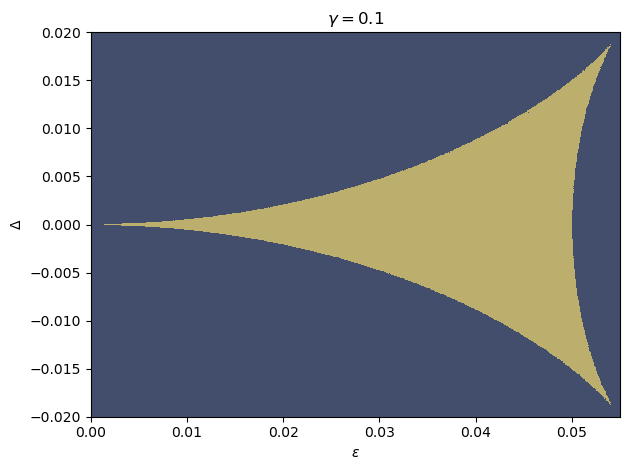

In [65]:
grid_length = 2000

epsilon_mesh_triangle, Delta_mesh_triangle, are_eigenvalues_real_array = Lindbladian_eigenvalues_triangle_calculator(Delta_min, Delta_max, epsilon_min, epsilon_max, gamma, grid_length)

# np.savetxt("4.1_epsilon_mesh_triangle.csv", epsilon_mesh_triangle, delimiter = ",")
# np.savetxt("4.1_Delta_mesh_triangle.csv", Delta_mesh_triangle, delimiter = ",")
# np.savetxt("4.1_are_eigenvalues_real_array.csv", are_eigenvalues_real_array, delimiter = ",")

# inside the triangle: only real eigenvalues. outside the triangle: complex eigenvalues
fig, ax = plt.subplots()
ax.contourf(epsilon_mesh_triangle, Delta_mesh_triangle, are_eigenvalues_real_array, cmap='cividis')
ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')
ax.set_title(f'$\gamma=$' + str(gamma))
plt.tight_layout()
# fig.savefig('3.3.1_eigenvalues_triangle.png')

print('inside the triangle: only real eigenvalues')
print('outside the triangle: complex eigenvalues')

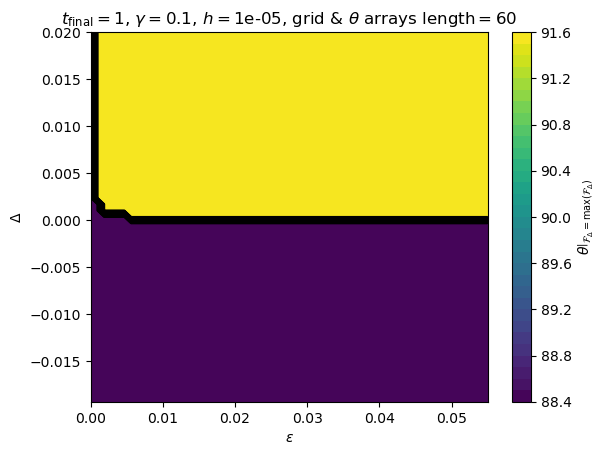

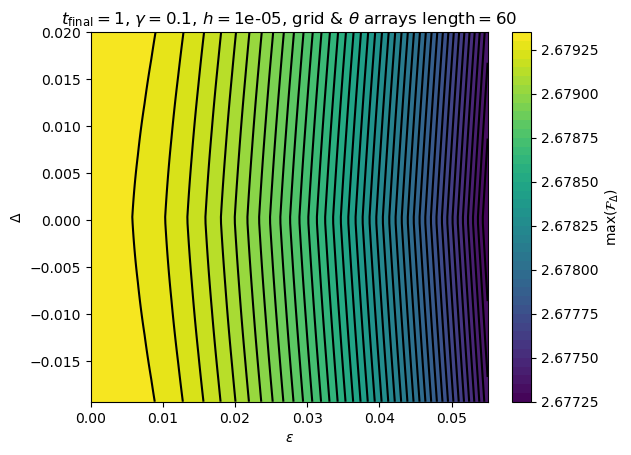

In [68]:
# "original"

# defining initial qubit
psi_0_0 = psi_0_0_generator()

t_final = 1

param_QFI = 'Delta'

h = 1e-5

# defining the length of theta_array and F_beta_array
theta_array_length = 60

grid_length = 60

# epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array, max_QFI_array = max_QFI_theta_epsilon_Delta_mesh_original(Delta_min, Delta_max, epsilon_min, epsilon_max, psi_0_0, t_final, gamma, param_QFI, h, theta_array_length, grid_length)

# np.savetxt("4.1_epsilon_mesh_QFI.csv", epsilon_mesh_QFI, delimiter = ",")
# np.savetxt("4.1_Delta_mesh_QFI.csv", Delta_mesh_QFI, delimiter = ",")
# np.savetxt("4.1_max_QFI_theta_array.csv", max_QFI_theta_array, delimiter = ",")
# np.savetxt("4.1_max_QFI_array.csv", max_QFI_array, delimiter = ",")


epsilon_mesh_QFI = pd.read_csv('4.1_epsilon_mesh_QFI.csv')
Delta_mesh_QFI = pd.read_csv('4.1_Delta_mesh_QFI.csv')
max_QFI_theta_array = pd.read_csv('4.1_max_QFI_theta_array.csv')
max_QFI_array = pd.read_csv('4.1_max_QFI_array.csv')


## max_QFI_theta_array_original(epsilon, Delta) contour
fig, ax = plt.subplots()

# Draw the filled contour plot
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30, colors='black')

ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

# # Add labels to the contour lines
# ax.clabel(contour_lines, inline=True, fontsize=8)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))
fig.savefig('4.1_max_QFI_theta_contour.png')
##

## max_QFI_theta_array_original(epsilon, Delta) contour
fig, ax = plt.subplots()

# Draw the filled contour plot
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50, colors='black')

ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

# # Add labels to the contour lines
# ax.clabel(contour_lines, inline=True, fontsize=8)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ arrays length}=$' + str(grid_length))

fig.savefig('4.1_max_QFI_contour.png')
##

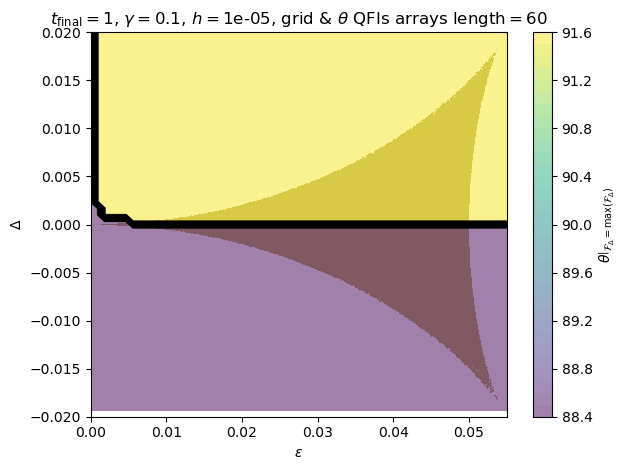

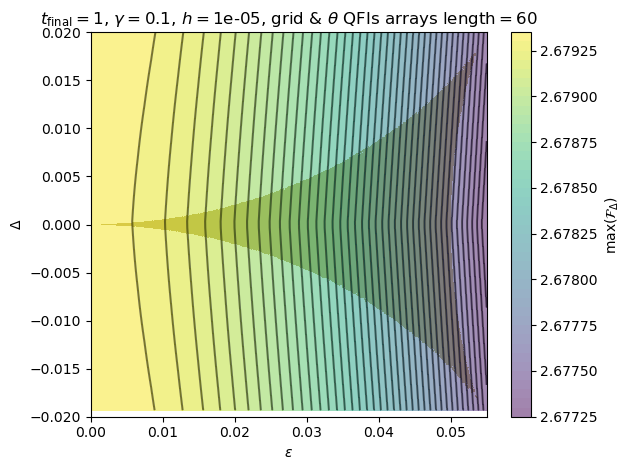

In [69]:
# Masking the False values in are_eigenvalues_real_array, insuring that the False values won't be plotted
masked_are_eigenvalues_real_array = np.ma.masked_where(are_eigenvalues_real_array==False, are_eigenvalues_real_array)


## for plotting max_QFI_theta_array & real eigenvalues triangle contour
fig, ax = plt.subplots()

# Plotting the triangle in which the eigenvalues are real
ax.contourf(epsilon_mesh_triangle, Delta_mesh_triangle, masked_are_eigenvalues_real_array, cmap='cividis')

# Draw the filled contour plot
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30, alpha=0.5)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30, colors='black', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ QFIs arrays length}=$' + str(grid_length))
ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

plt.tight_layout()

fig.savefig('4.1_max_QFI_theta_&_triangle_contour.png')
##


## for plotting max_QFI_array & real eigenvalues triangle contour
fig, ax = plt.subplots()

# Plotting the triangle in which the eigenvalues are real
ax.contourf(epsilon_mesh_triangle, Delta_mesh_triangle, masked_are_eigenvalues_real_array, cmap='cividis')

# Draw the filled contour plot of the maximum QFI obtained for each (epsilon, Delta) parameters
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50, alpha=0.5)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50, colors='black', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ QFIs arrays length}=$' + str(grid_length))
ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

plt.tight_layout()

fig.savefig('4.1_max_QFI_&_triangle_contour.png')
##

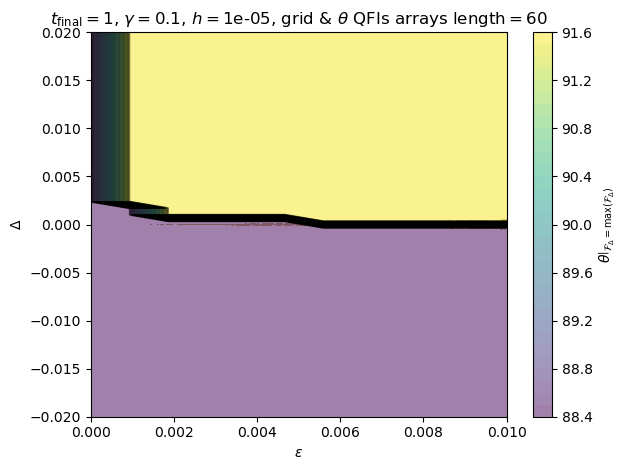

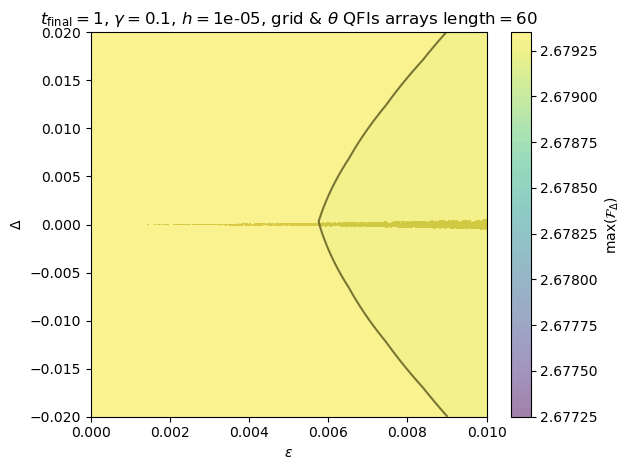

In [ ]:
# # reminder for the entire grid area
# Delta_min = -0.02
# Delta_max = 0.02
# epsilon_min = 0
# epsilon_max = 0.055

## area to zoom-in on, if desired
epsilon_1 = 0
epsilon_2 = 0.01
Delta_1 = - 0.02
Delta_2 = 0.02

if epsilon_1 < epsilon_min:
    print('epsilon_1 < epsilon_min')
elif epsilon_2 > epsilon_max:
    print('epsilon_2 > epsilon_max')
elif epsilon_2 > epsilon_1:
    print('epsilon_2 > epsilon_1')
elif Delta_1 < Delta_min:
    print('Delta_1 < Delta_min')
elif Delta_2 > Delta_max:
    print('Delta_2 > Delta_max')
elif Delta_2 > Delta_1:
    print('Delta_2 > Delta_1')
## 

# Masking the False values in are_eigenvalues_real_array, insuring that the False values won't be plotted
masked_are_eigenvalues_real_array = np.ma.masked_where(are_eigenvalues_real_array==False, are_eigenvalues_real_array)


## for plotting max_QFI_theta_array & real eigenvalues triangle contour
fig, ax = plt.subplots()

# Plotting the triangle in which the eigenvalues are real
ax.contourf(epsilon_mesh_triangle, Delta_mesh_triangle, masked_are_eigenvalues_real_array, cmap='cividis')

# Draw the filled contour plot
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30, alpha=0.5)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_theta_array*(180/np.pi), levels=30, colors='black', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\left.\theta\right|_{\mathcal{F}_{\Delta}=\max\left(\mathcal{F}_{\Delta}\right)}$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ QFIs arrays length}=$' + str(grid_length))
ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

ax.set_xlim(epsilon_1, epsilon_2)
ax.set_ylim(Delta_1, Delta_2)

plt.tight_layout()

# fig.savefig('4.1_max_QFI_theta_&_triangle_contour_closeup.png')
##


## for plotting max_QFI_array & real eigenvalues triangle contour
fig, ax = plt.subplots()

# Plotting the triangle in which the eigenvalues are real
ax.contourf(epsilon_mesh_triangle, Delta_mesh_triangle, masked_are_eigenvalues_real_array, cmap='cividis')

# Draw the filled contour plot of the maximum QFI obtained for each (epsilon, Delta) parameters
contour_filled = ax.contourf(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50, alpha=0.5)

# Draw the contour lines
contour_lines = ax.contour(epsilon_mesh_QFI, Delta_mesh_QFI, max_QFI_array, levels=50, colors='black', alpha=0.5)

# Add a colorbar
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label(r'$\max\left(\mathcal{F}_{\Delta}\right)$')

ax.set_title(r'$t_{\text{final}}=$' + str(t_final) + ', ' + r'$\gamma=$' + str(gamma) + ', ' + r'$h=$' + str(h) + ', ' + r'$\text{grid & }$' + r'$\theta$' + r'$\text{ QFIs arrays length}=$' + str(grid_length))
ax.set_xlabel(f'$\epsilon$')
ax.set_ylabel(f'$\Delta$')

ax.set_xlim(epsilon_1, epsilon_2)
ax.set_ylim(Delta_1, Delta_2)

plt.tight_layout()

# fig.savefig('4.1_max_QFI_&_triangle_contour_closeup.png')
##

## 5.

note: later, for the case $\kappa_{+},\kappa_{-}\neq0$, write a function that solves for (i.e. generates) $\vec{S}_{\text{eq}}$ according to the equation under $\left(\text{B.4}\right)$.



In our case, since $\kappa_{+}=\kappa_{-}=0$, then $\Gamma=-\gamma$, and

$$\vec{S}\left(t\right)=e^{-\gamma t}e^{Mt}\vec{S}_{0}$$

where

$$M=\begin{pmatrix}-\frac{\Gamma}{2} & \Delta & 0\\
-\Delta & -\frac{\Gamma}{2} & \epsilon\\
0 & -\epsilon & -\Gamma
\end{pmatrix}$$

and $\vec{S}_{0}=\vec{S}\left(0\right)$, which in our case is the state after rotating $\left|0\right\rangle$ by an angle of $\theta$ about $\hat{y}$.

In [89]:
def Gamma_generator(kappa_minus, kappa_plus, gamma):

    Gamma = kappa_minus + kappa_plus - gamma

    return Gamma

In [104]:
def M_matrix(Delta, epsilon, Gamma):

    # given the input parameters Delta, epsilon and gamma, representing the detuning, driving and dephasing rate respectively, M_matrix returns M, as it's defined in (B.5) in the article “Exceptional points for parameter estimation in open quantum systems: analysis of the Bloch equations”

    M = np.zeros([3, 3])

    M[0, 0] = - Gamma / 2
    M[0, 1] = Delta

    M[1, 0] = - Delta
    M[1, 1] = - Gamma / 2
    M[1, 2] = epsilon

    M[2, 1] = - epsilon
    M[2, 2] = - Gamma

    return M

In [159]:
def S_0_generator(psi_0_0, theta):

    # Hamiltonian H_1
    H_1 = sigmay()

    # final time of the rotation about the y-axis (taking into account that qutip uses hbar=1 units)
    t_1 = (1 / 2) * theta

    # time array of the rotation about the y-axis
    tlist = np.array([0, t_1])

    # time evolution of psi_0_0 for a duration of t_1, given the Hamiltonian H_1
    result = mesolve(H_1, psi_0_0, tlist, c_ops=None, e_ops=[sigmax(), sigmay(), sigmaz()])

    # list of the np.arrays of the pauli matrices expectation values corresponding to the time values in tlist
    pauli_exp_vals = result.expect

    # creating the bloch vector of the state at the final time t_1, i.e. a np.array of the pauli matrices expectation values in the final time t_1, via extracting the last element of each inner array using list comprehension
    r = np.array([arr[-1] for arr in pauli_exp_vals])

    # since the bloch vector's components are given by the expectation values of the pauli matrices, and the spin operator vector is given by the spin-1/2 operator S_vec=(hbar/2)*sigma_vec, where ... spin 1/2 system... complete the explanation more precisely later
    S_0 = (1/2) * r

    return S_0

In [ ]:
# def S_eq_generator(kappa_minus, kappa_plus, gamma):

In [149]:
# maybe obsolete. trying a different implementation ahead

def S_t_generator(gamma, t_final, M, S_0, S_eq):

    S_t = np.exp((-gamma) * t_final) * np.dot(expm(M * t_final), np.reshape(S_0 - S_eq, (3, 1))) + np.reshape(S_eq, (3, 1))

    return S_t

In [158]:
# maybe obsolete. trying a different implementation ahead

theta = np.pi / 2

Delta = 1
epsilon = 0.2
t_final = 1

kappa_minus = 0
kappa_plus = 0
gamma = 0.1
Gamma = Gamma_generator(kappa_minus, kappa_plus, gamma)

M = M_matrix(Delta, epsilon, Gamma)

psi_0_0 = psi_0_0_generator()

S_0 = S_0_generator(psi_0_0, theta)

# since kappa_minus = kappa_plus = 0 in this case. for the general case, make a function S_eq_generator() that solves for S_eq, and replace this code line with S_eq = S_eq_generator(kappa_minus, kappa_plus, gamma)
S_eq = np.zeros(3)

S_t = S_t_generator(gamma, t_final, M, S_0, S_eq)

# the corresponding bloch vector
r_t = 2 * S_t

According to the article "Quantum Fisher information matrix and multiparameter estimation", for a single-qubit mixed state, the QFIM in Bloch representation can be expressed by

$$\left(24\right)\,\,\,\,\mathcal{F}_{ab}=\left(\partial_{a}\vec{r}\right)\cdot\left(\partial_{b}\vec{r}\right)+\frac{\left(\vec{r}\cdot\partial_{a}\vec{r}\right)\left(\vec{r}\cdot\partial_{b}\vec{r}\right)}{1-\left|\vec{r}\right|^{2}}$$

In [ ]:
def QFI_calculator_24(psi_0_0, theta, param_vec, param_QFI, h=1e-8):

    param_names = np.array(['beta', 'Delta', 'epsilon', 'kappa_minus', 'kappa_plus','gamma']) # names of the parameters for which the QFI can be calculated. note that beta=(2*Delta)*t_final (taking into account that qutip uses hbar=1 units), and it can be shown without difficulty that d_beta=h*beta dictates that d_t_final=h*t_final
    param_QFI_index = np.where(param_names == param_QFI)[0][0] # the index in param_vec corresponding to param_QFI
    param_vec_p = param_vec.copy()
    param_vec_m = param_vec.copy()
    d_param_QFI = h * param_vec[param_QFI_index] # small change in the value of param_QFI
    param_vec_p[param_QFI_index] += d_param_QFI # in param_vec_p, the value of param_QFI is changed into param_QFI+d_param_QFI. p:=+d_param_QFI
    param_vec_m[param_QFI_index] -= d_param_QFI # in param_vec_m, the value of param_QFI is changed into param_QFI-d_param_QFI. m:=-d_param_QFI
    
    S_0 = S_0_generator(psi_0_0, theta)

    ...
    continue from here later





    dm_0_0 = ket2dm(psi_0_0) # the density matrix of the initial state vector
    
    # the density matrix of the qubit obtained from psi_0_0 by rotating it (counter-clockwise) by an angle of theta about the y-axis
    dm_theta_0 = y_rotation(dm_0_0, theta)

    # the density matrix of qubit obtained from psi_theta_0 by evolving it under the Hamiltonian H = (Delta * sigmaz()) + (epsilon * sigmax()) and collapse operator dephasing_collapse_operator = np.sqrt(gamma) * sigmaz() for a duration of t_final
    dm = z_rotation(dm_theta_0, param_vec) # dm:=dm_theta_beta
    
    # calculating the (3-points numerical) derivative of dm_theta_beta with respect to param_QFI
    dm_p = z_rotation(dm_theta_0, param_vec_p) # p:=+d_param_QFI
    dm_m = z_rotation(dm_theta_0, param_vec_m) # m:=-d_param_QFI
    ddm_dparam_QFI = (dm_p - dm_m) / (2 * d_param_QFI) # ddm_dparam_QFI:=d(dm_theta_beta)/d(param_QFI), i.e. the (3-points numerical) derivative of dm_theta_beta with respect to param_QFI
    
    # if param_QFI = 'beta', the above procedure actually calculated d(dm_theta_beta)/d(t_final). it is converted to d(dm_theta_beta)/d(beta) by multiplying it by a factor of (1 / (2 * Delta))
    if param_QFI == 'beta':
        Delta = param_vec[1]
        ddm_dparam_QFI = (1 / (2 * Delta)) * ddm_dparam_QFI